In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [10]:
import gensim
import numpy as np
import json
import re
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, eigs
import torch

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline

!pip install nltk==3.6.2
import nltk
from nltk import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

     |████████████████████████████████| 1.5 MB 8.9 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print(nltk.__version__)

3.6.2


In [12]:
PATH = "/content/drive/MyDrive/NLP/Assignment-1/Dataset/Electronics_5.json"
model_path = "/content/drive/MyDrive/NLP/Assignment-1/outputs/Q1/model.pt"
vocab_path = "/content/drive/MyDrive/NLP/Assignment-1/outputs/Q1/vocab.pt"
embed_path = "/content/drive/MyDrive/NLP/Assignment-1/outputs/Q1/embed.npy"
plot_path  = "/content/drive/MyDrive/NLP/Assignment-1/outputs/Q1/plot.png"

# 16,89,188 review paras

In [3]:
class Sentence():
    '''
    Sentence Generator class
    '''

    # Init method - initialize object with corpus file path
    def __init__(self, PATH):
        self.PATH = PATH

    # Method to preprocess the sentence
    def preprocess(self, sentence):
        if not sentence.isspace():
            return re.sub("[^a-zA-Z0-9 ]", " ", sentence).lower().strip()

    # Generator method - yields one sentence at a time
    def __iter__(self):
        for i, line in enumerate(open(self.PATH)):
            para = json.loads(line)['reviewText']
            for sent in sent_tokenize(para):
                yield ['SOS'] + self.preprocess(sent).split() + ['EOS']


class Vocabulary():
    '''
    Vocabulary class
    '''

    # Init method - initialize object with various mappings
    def __init__(self, sentences, freqlimit):
        self.word2ind = {
            'UNK': 0,
            'SOS': 1,
            'EOS': 2
        }
        self.ind2word = {
            0: 'UNK',
            1: 'SOS',
            2: 'EOS'
        }
        self.word2freq = {
            'UNK': 0,
            'SOS': 0,
            'EOS': 0
        }
        self.vocabsize = 3

        self.add_corpus(sentences)
        self.delete_low_freq(freqlimit)
        self.prepare_vocab()

    # Method to iteratively add corpus sentences
    def add_corpus(self, sentences):
        for sent in sentences:
            for word in sent:
                self.add_word(word)

    # Method to add word into frequency mapping
    def add_word(self, word):
        if word not in self.word2freq:
            self.word2freq[word] = 1
        else:
            self.word2freq[word] += 1

    # Method to delete low frequency words from frequency mapping
    def delete_low_freq(self, freqlimit):
        delete_keys = [key for key in self.word2freq if self.word2freq[key] < freqlimit]

        for key in delete_keys:
            del self.word2freq[key]

    # Method to prepare vocabulary with word2ind and ind2word mappings
    def prepare_vocab(self):
        for word in self.word2freq:
            if word not in self.word2ind:
                self.word2ind[word] = self.vocabsize
                self.ind2word[self.vocabsize] = word
                self.vocabsize += 1

    # Getter method - return integer mapping of input word
    def get_ind(self, word):
        if word not in self.word2ind:
            return self.word2ind['UNK']
        return self.word2ind[word]

    # Getter method - return word corresponding to input integer
    def get_word(self, ind):
        if ind not in self.ind2word:
            return self.ind2word[0]
        return self.ind2word[ind]

    # Getter method - return frequency of the input word
    def get_freq(self, word):
        if word not in self.word2freq:
            return self.word2freq['UNK']
        return self.word2freq[word]

In [ ]:
sentences = Sentence(PATH)
Vocab = Vocabulary(sentences, 5)

# 5,11,595 words in vocab

In [4]:
class WordEmbedModel():
    '''
    Word Embedding Model class
    '''

    # Init method - initialize object with context window size and embedding size
    def __init__(self, context_size, embed_size, vocab):
        self.context_size = context_size
        self.embed_size = embed_size
        self.vocab = vocab
        self.embeddings = []

    # Method to train the model (SVD on Co-Occurrence matrix)
    def train(self, sentences):
        print("Starting training")

        map = self.prepare_map(sentences)
        print("Mapping completed")

        row_ind = []
        col_ind = []
        data = []

        print("Preparing co-ocuurence matrix indices")
        while map:
            rword, tmp = map.popitem()
            for cword in tmp:
                row_ind.append(self.vocab.get_ind(rword))
                col_ind.append(self.vocab.get_ind(cword))
                data.append(tmp[cword])

        print("Preparing co-occurence matrix")
        co_occur = csr_matrix((data, (row_ind, col_ind)), shape=(self.vocab.vocabsize, self.vocab.vocabsize), dtype=float)
        
        del row_ind
        del col_ind
        del data
        
        print('SVD')
        self.embeddings, _, _ = svds(co_occur, self.embed_size)
        del co_occur

        print('Training completed')

    # Method to prepare the mappings of Co-Occurrence matrix
    def prepare_map(self, sentences):
        map = {}

        for sent in sentences:
            sent = list(filter(lambda i: i in self.vocab.word2ind, sent))
            for i, word in enumerate(sent):
                if word not in map:
                    map[word] = {}

                for j in range(i+1, min(i+1+self.context_size, len(sent))):
                    if sent[j] not in map:
                        map[sent[j]] = {}

                    if sent[j] not in map[word]:
                        map[word][sent[j]] = 0
                    map[word][sent[j]] += 1

                    if word not in map[sent[j]]:
                        map[sent[j]][word] = 0
                    map[sent[j]][word] += 1

        return map

    # Getter method - return embedding of the input word
    def get_embedding(self, word):
        return self.embeddings[self.vocab.get_ind(word)]

    # Getter method - return top n similar words of input word
    def similar_words(self, word, top):
        word_embed = self.embeddings[self.vocab.get_ind(word)]
        cos_dist = 1 - np.dot(self.embeddings, word_embed)/(np.linalg.norm(self.embeddings, axis=1)*np.linalg.norm(word_embed))

        sorted_inds = np.argsort(cos_dist)[:top]
        return [(self.vocab.get_word(ind), 1-cos_dist[ind]) for ind in sorted_inds]

In [ ]:
model = WordEmbedModel(context_size=3, embed_size=50, vocab=Vocab)
model.train(sentences)

Starting training
Mapping completed
Preparing co-ocuurence matrix indices
Preparing co-occurence matrix
SVD
Training completed


In [ ]:
torch.save(model, model_path)
torch.save(Vocab, vocab_path)
np.save(embed_path, model.embeddings)

In [ ]:
print("Top 10 similar words obtained by Word Embedding Model for the word camera are,", model.similar_words('camera', 10))

Top 10 similar words obtained by Word Embedding Model for the word camera are, [('camera', 0.9999999999999998), ('cam', 0.9371049060515714), ('psu', 0.921371199543117), ('projector', 0.9202497342633565), ('detector', 0.9163765162074519), ('hu', 0.914285371611892), ('headset', 0.9119752431055327), ('router', 0.8968091957484156), ('player', 0.8877756433196792), ('radio', 0.8823712782394749)]


# Generating t-SNE plot for keywords

In [7]:
# Method to create embedding clusters list and word clusters list
def get_clusters(keywords, model):
    embedding_clusters = []
    word_clusters = []

    for word in keywords:
        embeddings = []
        words = []

        for similar_word, _ in model.similar_words(word, 11):
            words.append(similar_word)
            embeddings.append(model.get_embedding(similar_word))
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    
    embedding_clusters = np.array(embedding_clusters)

    return embedding_clusters, word_clusters

# Function to plot the t-SNE plot given the clusters information
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[1:, 0]
        y = embeddings[1:, 1]

        if words[0] != 'they':
            plt.scatter(embeddings[0, 0], embeddings[0, 1], c="black", alpha=0.7)
            plt.annotate(words[0], alpha=1, xy=(embeddings[0, 0], embeddings[0, 1]), xytext=(5, 2),
                        textcoords='offset points', ha='right', va='bottom', size=8)

        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words[1:]):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

# Function to plot the t-SNE plot
def plot_tsne(keywords, model):
    embed_clusters, word_clusters = get_clusters(keywords, model)

    n, m, k = embed_clusters.shape
    tsne_model_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000, random_state=16)
    embeddings_2d = np.array(tsne_model_2d.fit_transform(embed_clusters.reshape(n * m, k))).reshape(n, m, 2)

    tsne_plot_similar_words('Similar words from Electronics Review Dataset', keywords, embeddings_2d, word_clusters, plot_path)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

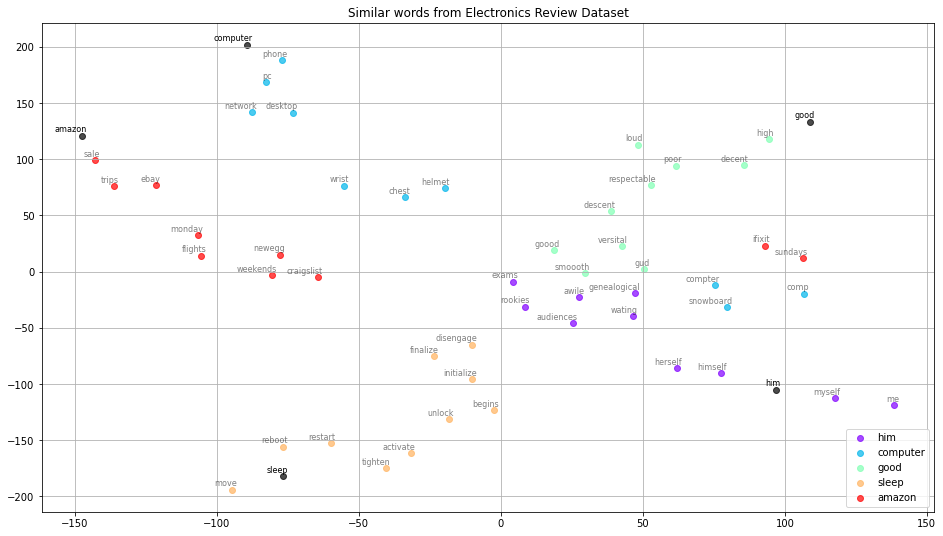

In [13]:
keywords = ['him', 'computer', 'good', 'sleep', 'amazon']

plot_tsne(keywords, model)